In [1]:
import pandas as pd

pd.options.plotting.backend = "plotly"

In [2]:
df_train = pd.read_csv('../data/df_train.csv', sep = ',')
df_eval = pd.read_csv('../data/df_eval.csv', sep=',')

In [3]:
y_cols = ["OS_YEARS", "OS_STATUS"]
X_train = df_train.drop(columns=y_cols)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px

# Standardize
scaler = StandardScaler()
X_std = scaler.fit_transform(X_train.select_dtypes(include='number'))

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# DataFrame for plotting
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['OS_STATUS'] = df_train['OS_STATUS']

# Plot
fig = px.scatter(df_pca, x='PC1', y='PC2', color='OS_STATUS',
                 title='PCA (Standardized) of X_train colored by OS_STATUS')
fig.show()


In [5]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, learning_rate='auto', init='pca')
X_tsne = tsne.fit_transform(X_std)

df_tsne = pd.DataFrame(X_tsne, columns=['tSNE1', 'tSNE2'])
df_tsne['OS_STATUS'] = df_train['OS_STATUS']

fig_tsne = px.scatter(df_tsne, x='tSNE1', y='tSNE2', color='OS_STATUS',
                      title='t-SNE (Standardized) of X_train colored by OS_STATUS')
fig_tsne.show()

In [6]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

y = df_train["OS_STATUS"].astype(int)
X = X_train

clf = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_proba = cross_val_predict(clf, X, y, cv=cv, method="predict_proba")[:, 1]

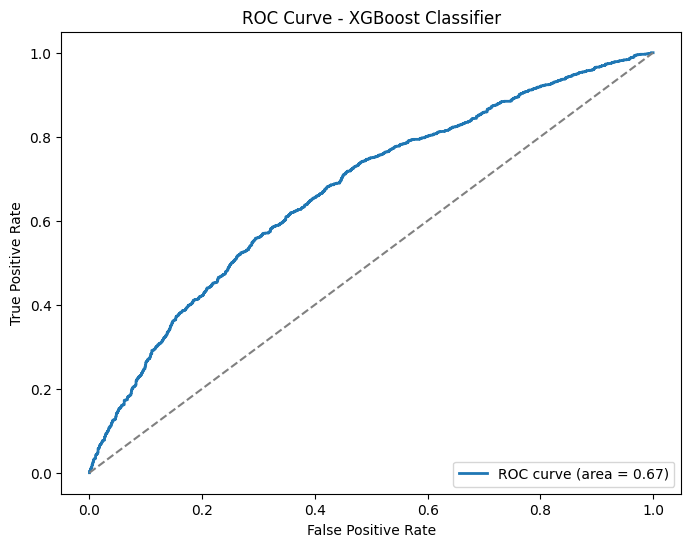

In [7]:
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], '--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost Classifier')
plt.legend(loc="lower right")
plt.show()

In [9]:
from sklearn.model_selection import cross_val_score

auc_scores = cross_val_score(clf, X, y, cv=cv, scoring="f1")
auc_scores

array([0.65486726, 0.61264182, 0.63551402, 0.63855422, 0.62776025])

**Summary of Results**

- ROC AUC (mean/std) from 5-fold cross-validation is shown above.
- ROC curve for the XGBoost classifier using all features, with rigorous cross-validation, is plotted above.


## Advanced Model with Hyperparameter Tuning

Creating an optimized ensemble model using hyperparameter tuning with Optuna, feature selection, and advanced techniques.

In [11]:
import optuna
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import numpy as np

C:\Users\Concordance\PycharmProjects\QRT-Challenge-2025\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [12]:
def objective(trial):
    model_type = trial.suggest_categorical('model', ['xgboost', 'rf', 'gb'])

    n_features = trial.suggest_int('n_features', 10, X_train.shape[1])

    if model_type == 'xgboost':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
            'eval_metric': 'logloss',
            'random_state': 42
        }
        model = xgb.XGBClassifier(**params)

    elif model_type == 'rf':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 20),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
            'random_state': 42
        }
        model = RandomForestClassifier(**params)

    else:
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'random_state': 42
        }
        model = GradientBoostingClassifier(**params)

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(f_classif, k=n_features)),
        ('classifier', model)
    ])

    scores = cross_val_score(pipeline, X, y, cv=cv, scoring='roc_auc', n_jobs=-1)

    return scores.mean()

In [13]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100, show_progress_bar=True)

[I 2025-09-30 23:39:54,437] A new study created in memory with name: no-name-0e5ec275-fa85-4426-b7ae-71d5dbe0dbb8
Best trial: 0. Best value: 0.705896:   1%|          | 1/100 [00:07<11:45,  7.12s/it]

[I 2025-09-30 23:40:01,560] Trial 0 finished with value: 0.705896263016884 and parameters: {'model': 'rf', 'n_features': 158, 'n_estimators': 162, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.705896263016884.


Best trial: 1. Best value: 0.711134:   2%|▏         | 2/100 [00:10<08:13,  5.04s/it]

[I 2025-09-30 23:40:05,143] Trial 1 finished with value: 0.7111338653826711 and parameters: {'model': 'rf', 'n_features': 62, 'n_estimators': 172, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.7111338653826711.


Best trial: 1. Best value: 0.711134:   3%|▎         | 3/100 [00:15<07:39,  4.74s/it]

[I 2025-09-30 23:40:09,525] Trial 2 finished with value: 0.6979854033970276 and parameters: {'model': 'xgboost', 'n_features': 100, 'n_estimators': 282, 'max_depth': 9, 'learning_rate': 0.06790539682592432, 'subsample': 0.8056937753654446, 'colsample_bytree': 0.836965827544817, 'gamma': 0.23225206359998862, 'reg_alpha': 6.075448519014383, 'reg_lambda': 1.7052412368729153}. Best is trial 1 with value: 0.7111338653826711.


Best trial: 1. Best value: 0.711134:   4%|▍         | 4/100 [00:25<11:05,  6.94s/it]

[I 2025-09-30 23:40:19,826] Trial 3 finished with value: 0.7004175449903953 and parameters: {'model': 'gb', 'n_features': 210, 'n_estimators': 222, 'learning_rate': 0.03832491306185132, 'max_depth': 8, 'subsample': 0.7760609974958406, 'min_samples_split': 3}. Best is trial 1 with value: 0.7111338653826711.


Best trial: 1. Best value: 0.711134:   5%|▌         | 5/100 [00:33<11:45,  7.43s/it]

[I 2025-09-30 23:40:28,128] Trial 4 finished with value: 0.6827764760893741 and parameters: {'model': 'gb', 'n_features': 74, 'n_estimators': 365, 'learning_rate': 0.10039621206592916, 'max_depth': 7, 'subsample': 0.8186841117373118, 'min_samples_split': 3}. Best is trial 1 with value: 0.7111338653826711.


Best trial: 5. Best value: 0.719688:   6%|▌         | 6/100 [00:34<08:17,  5.30s/it]

[I 2025-09-30 23:40:29,290] Trial 5 finished with value: 0.719687847538166 and parameters: {'model': 'xgboost', 'n_features': 231, 'n_estimators': 339, 'max_depth': 10, 'learning_rate': 0.03566282559505665, 'subsample': 0.6783931449676581, 'colsample_bytree': 0.6180909155642152, 'gamma': 1.6266516538163218, 'reg_alpha': 3.8867728968948203, 'reg_lambda': 2.713490317738959}. Best is trial 5 with value: 0.719687847538166.


Best trial: 5. Best value: 0.719688:   7%|▋         | 7/100 [00:36<06:24,  4.13s/it]

[I 2025-09-30 23:40:31,026] Trial 6 finished with value: 0.7040935635931654 and parameters: {'model': 'xgboost', 'n_features': 144, 'n_estimators': 156, 'max_depth': 9, 'learning_rate': 0.03161968666713354, 'subsample': 0.9947547746402069, 'colsample_bytree': 0.908897907718663, 'gamma': 0.993578407670862, 'reg_alpha': 0.05522117123602399, 'reg_lambda': 8.154614284548341}. Best is trial 5 with value: 0.719687847538166.


Best trial: 5. Best value: 0.719688:   8%|▊         | 8/100 [00:40<06:22,  4.16s/it]

[I 2025-09-30 23:40:35,253] Trial 7 finished with value: 0.6891125612930946 and parameters: {'model': 'gb', 'n_features': 28, 'n_estimators': 243, 'learning_rate': 0.04360202726228762, 'max_depth': 9, 'subsample': 0.8493192507310232, 'min_samples_split': 4}. Best is trial 5 with value: 0.719687847538166.


Best trial: 5. Best value: 0.719688:   9%|▉         | 9/100 [00:48<07:46,  5.13s/it]

[I 2025-09-30 23:40:42,509] Trial 8 finished with value: 0.6628770157213628 and parameters: {'model': 'gb', 'n_features': 190, 'n_estimators': 355, 'learning_rate': 0.2672916953471347, 'max_depth': 6, 'subsample': 0.6478376983753207, 'min_samples_split': 8}. Best is trial 5 with value: 0.719687847538166.


Best trial: 5. Best value: 0.719688:  10%|█         | 10/100 [00:51<06:46,  4.51s/it]

[I 2025-09-30 23:40:45,636] Trial 9 finished with value: 0.6814530570720858 and parameters: {'model': 'gb', 'n_features': 132, 'n_estimators': 309, 'learning_rate': 0.1339868953239794, 'max_depth': 3, 'subsample': 0.6431565707973218, 'min_samples_split': 2}. Best is trial 5 with value: 0.719687847538166.


Best trial: 5. Best value: 0.719688:  11%|█         | 11/100 [00:52<05:04,  3.42s/it]

[I 2025-09-30 23:40:46,589] Trial 10 finished with value: 0.7192151387625113 and parameters: {'model': 'xgboost', 'n_features': 241, 'n_estimators': 488, 'max_depth': 10, 'learning_rate': 0.21739918753707055, 'subsample': 0.7158512999551032, 'colsample_bytree': 0.6060517720062442, 'gamma': 4.0971404077283955, 'reg_alpha': 2.776407092033357, 'reg_lambda': 2.1258357580538636}. Best is trial 5 with value: 0.719687847538166.


Best trial: 5. Best value: 0.719688:  12%|█▏        | 12/100 [00:53<03:52,  2.64s/it]

[I 2025-09-30 23:40:47,447] Trial 11 finished with value: 0.7189802471944191 and parameters: {'model': 'xgboost', 'n_features': 248, 'n_estimators': 485, 'max_depth': 10, 'learning_rate': 0.21887870670545195, 'subsample': 0.7203652920255712, 'colsample_bytree': 0.6043249449253474, 'gamma': 4.677314712121136, 'reg_alpha': 2.6699107294536955, 'reg_lambda': 2.14371635598811}. Best is trial 5 with value: 0.719687847538166.


Best trial: 5. Best value: 0.719688:  13%|█▎        | 13/100 [00:53<02:59,  2.07s/it]

[I 2025-09-30 23:40:48,195] Trial 12 finished with value: 0.7185067485592962 and parameters: {'model': 'xgboost', 'n_features': 257, 'n_estimators': 499, 'max_depth': 10, 'learning_rate': 0.1920164541242254, 'subsample': 0.7021668672349292, 'colsample_bytree': 0.6012854769286154, 'gamma': 3.264648750204892, 'reg_alpha': 3.781980143889722, 'reg_lambda': 3.508541947145841}. Best is trial 5 with value: 0.719687847538166.


Best trial: 5. Best value: 0.719688:  14%|█▍        | 14/100 [00:54<02:20,  1.63s/it]

[I 2025-09-30 23:40:48,819] Trial 13 finished with value: 0.7105870993832777 and parameters: {'model': 'xgboost', 'n_features': 213, 'n_estimators': 426, 'max_depth': 10, 'learning_rate': 0.29766848925630124, 'subsample': 0.614695892474699, 'colsample_bytree': 0.7135330045391114, 'gamma': 2.287390758709396, 'reg_alpha': 9.136025859404633, 'reg_lambda': 0.037473329442913705}. Best is trial 5 with value: 0.719687847538166.


Best trial: 5. Best value: 0.719688:  15%|█▌        | 15/100 [00:55<01:56,  1.37s/it]

[I 2025-09-30 23:40:49,568] Trial 14 finished with value: 0.7054082120109191 and parameters: {'model': 'xgboost', 'n_features': 221, 'n_estimators': 419, 'max_depth': 8, 'learning_rate': 0.178112007028383, 'subsample': 0.7183488811082996, 'colsample_bytree': 0.6772876502180768, 'gamma': 2.4013441427675764, 'reg_alpha': 2.3999107072026513, 'reg_lambda': 5.599296884608052}. Best is trial 5 with value: 0.719687847538166.


Best trial: 5. Best value: 0.719688:  16%|█▌        | 16/100 [00:55<01:29,  1.07s/it]

[I 2025-09-30 23:40:49,934] Trial 15 finished with value: 0.7169068724092609 and parameters: {'model': 'xgboost', 'n_features': 181, 'n_estimators': 106, 'max_depth': 4, 'learning_rate': 0.22843904055035277, 'subsample': 0.9311149037830162, 'colsample_bytree': 0.727322797767566, 'gamma': 4.898232498406144, 'reg_alpha': 5.625128570253415, 'reg_lambda': 5.160286386845208}. Best is trial 5 with value: 0.719687847538166.


Best trial: 5. Best value: 0.719688:  17%|█▋        | 17/100 [00:56<01:21,  1.01it/s]

[I 2025-09-30 23:40:50,735] Trial 16 finished with value: 0.705356593114953 and parameters: {'model': 'xgboost', 'n_features': 236, 'n_estimators': 435, 'max_depth': 8, 'learning_rate': 0.13649978960074016, 'subsample': 0.6850392153926411, 'colsample_bytree': 0.9797219789344327, 'gamma': 3.4483721260588363, 'reg_alpha': 0.734394501321928, 'reg_lambda': 3.20339735257917}. Best is trial 5 with value: 0.719687847538166.


Best trial: 5. Best value: 0.719688:  18%|█▊        | 18/100 [00:57<01:29,  1.10s/it]

[I 2025-09-30 23:40:52,086] Trial 17 finished with value: 0.712735270700637 and parameters: {'model': 'rf', 'n_features': 176, 'n_estimators': 358, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 5 with value: 0.719687847538166.


Best trial: 5. Best value: 0.719688:  19%|█▉        | 19/100 [00:58<01:19,  1.02it/s]

[I 2025-09-30 23:40:52,806] Trial 18 finished with value: 0.7046592988575473 and parameters: {'model': 'xgboost', 'n_features': 111, 'n_estimators': 463, 'max_depth': 10, 'learning_rate': 0.08928657722615016, 'subsample': 0.7529036953467247, 'colsample_bytree': 0.6622717489721398, 'gamma': 1.5051524666263352, 'reg_alpha': 4.4299848054420625, 'reg_lambda': 0.12194053749907274}. Best is trial 5 with value: 0.719687847538166.


Best trial: 19. Best value: 0.72049:  20%|██        | 20/100 [00:59<01:14,  1.08it/s]

[I 2025-09-30 23:40:53,607] Trial 19 finished with value: 0.7204902942068546 and parameters: {'model': 'xgboost', 'n_features': 203, 'n_estimators': 316, 'max_depth': 7, 'learning_rate': 0.010732457990068913, 'subsample': 0.6690182046395355, 'colsample_bytree': 0.7866682898732238, 'gamma': 3.8618195456958286, 'reg_alpha': 7.435774757558886, 'reg_lambda': 7.0140201169070675}. Best is trial 19 with value: 0.7204902942068546.


Best trial: 19. Best value: 0.72049:  21%|██        | 21/100 [01:00<01:32,  1.17s/it]

[I 2025-09-30 23:40:55,341] Trial 20 finished with value: 0.7128572945101608 and parameters: {'model': 'rf', 'n_features': 191, 'n_estimators': 312, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'sqrt'}. Best is trial 19 with value: 0.7204902942068546.


Best trial: 21. Best value: 0.724445:  22%|██▏       | 22/100 [01:01<01:22,  1.06s/it]

[I 2025-09-30 23:40:56,144] Trial 21 finished with value: 0.724444551865332 and parameters: {'model': 'xgboost', 'n_features': 231, 'n_estimators': 384, 'max_depth': 7, 'learning_rate': 0.02783689741795342, 'subsample': 0.6666930143084837, 'colsample_bytree': 0.7741966626735901, 'gamma': 3.821346518465741, 'reg_alpha': 8.238140023999302, 'reg_lambda': 7.81985302744173}. Best is trial 21 with value: 0.724444551865332.


Best trial: 21. Best value: 0.724445:  23%|██▎       | 23/100 [01:02<01:16,  1.01it/s]

[I 2025-09-30 23:40:56,966] Trial 22 finished with value: 0.7232700245172378 and parameters: {'model': 'xgboost', 'n_features': 225, 'n_estimators': 381, 'max_depth': 7, 'learning_rate': 0.02350540517731975, 'subsample': 0.6084650594852372, 'colsample_bytree': 0.7864918392257991, 'gamma': 3.3947622122797076, 'reg_alpha': 7.937402424425625, 'reg_lambda': 7.928070077953203}. Best is trial 21 with value: 0.724444551865332.


Best trial: 21. Best value: 0.724445:  24%|██▍       | 24/100 [01:03<01:13,  1.04it/s]

[I 2025-09-30 23:40:57,875] Trial 23 finished with value: 0.7218713729653219 and parameters: {'model': 'xgboost', 'n_features': 202, 'n_estimators': 385, 'max_depth': 7, 'learning_rate': 0.01161405968218659, 'subsample': 0.611519033026369, 'colsample_bytree': 0.7970708972907418, 'gamma': 3.581165320998806, 'reg_alpha': 8.264764896780957, 'reg_lambda': 8.44141893006478}. Best is trial 21 with value: 0.724444551865332.


Best trial: 21. Best value: 0.724445:  25%|██▌       | 25/100 [01:04<01:03,  1.17it/s]

[I 2025-09-30 23:40:58,468] Trial 24 finished with value: 0.7235998319179051 and parameters: {'model': 'xgboost', 'n_features': 170, 'n_estimators': 392, 'max_depth': 6, 'learning_rate': 0.0704801571783037, 'subsample': 0.6100228229843884, 'colsample_bytree': 0.8014906068750177, 'gamma': 3.0790637686957694, 'reg_alpha': 9.759522310646888, 'reg_lambda': 9.844871488579383}. Best is trial 21 with value: 0.724444551865332.


Best trial: 21. Best value: 0.724445:  26%|██▌       | 26/100 [01:04<00:57,  1.29it/s]

[I 2025-09-30 23:40:59,061] Trial 25 finished with value: 0.7240254018804974 and parameters: {'model': 'xgboost', 'n_features': 162, 'n_estimators': 393, 'max_depth': 5, 'learning_rate': 0.07582558439167844, 'subsample': 0.6142711211316342, 'colsample_bytree': 0.8732207509663171, 'gamma': 2.827744037859708, 'reg_alpha': 9.686032545137596, 'reg_lambda': 9.905625093653086}. Best is trial 21 with value: 0.724444551865332.


Best trial: 21. Best value: 0.724445:  27%|██▋       | 27/100 [01:05<00:52,  1.40it/s]

[I 2025-09-30 23:40:59,628] Trial 26 finished with value: 0.7228301233444545 and parameters: {'model': 'xgboost', 'n_features': 164, 'n_estimators': 397, 'max_depth': 5, 'learning_rate': 0.07323427322182499, 'subsample': 0.6401429042561971, 'colsample_bytree': 0.8575960617283953, 'gamma': 2.7427688133716925, 'reg_alpha': 9.852077475702728, 'reg_lambda': 9.927551200845077}. Best is trial 21 with value: 0.724444551865332.


Best trial: 21. Best value: 0.724445:  28%|██▊       | 28/100 [01:05<00:45,  1.57it/s]

[I 2025-09-30 23:41:00,090] Trial 27 finished with value: 0.7217315741583258 and parameters: {'model': 'xgboost', 'n_features': 131, 'n_estimators': 274, 'max_depth': 5, 'learning_rate': 0.11263755857205734, 'subsample': 0.6025751497585693, 'colsample_bytree': 0.8957336885110039, 'gamma': 2.93667174435506, 'reg_alpha': 9.913041883944414, 'reg_lambda': 9.7705243152352}. Best is trial 21 with value: 0.724444551865332.


Best trial: 21. Best value: 0.724445:  29%|██▉       | 29/100 [01:06<00:44,  1.61it/s]

[I 2025-09-30 23:41:00,679] Trial 28 finished with value: 0.7215783666969973 and parameters: {'model': 'xgboost', 'n_features': 157, 'n_estimators': 443, 'max_depth': 4, 'learning_rate': 0.06199633116222972, 'subsample': 0.6533839254164349, 'colsample_bytree': 0.7378906712111089, 'gamma': 4.292909747903952, 'reg_alpha': 7.034399501018864, 'reg_lambda': 9.037200373328085}. Best is trial 21 with value: 0.724444551865332.


Best trial: 21. Best value: 0.724445:  30%|███       | 30/100 [01:07<01:02,  1.11it/s]

[I 2025-09-30 23:41:02,219] Trial 29 finished with value: 0.7136047480032353 and parameters: {'model': 'rf', 'n_features': 156, 'n_estimators': 404, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 21 with value: 0.724444551865332.


Best trial: 21. Best value: 0.724445:  31%|███       | 31/100 [01:09<01:27,  1.27s/it]

[I 2025-09-30 23:41:04,351] Trial 30 finished with value: 0.7136167728237792 and parameters: {'model': 'rf', 'n_features': 109, 'n_estimators': 460, 'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 21 with value: 0.724444551865332.


Best trial: 21. Best value: 0.724445:  32%|███▏      | 32/100 [01:10<01:12,  1.07s/it]

[I 2025-09-30 23:41:04,957] Trial 31 finished with value: 0.7237248508745324 and parameters: {'model': 'xgboost', 'n_features': 172, 'n_estimators': 386, 'max_depth': 6, 'learning_rate': 0.056263063162846974, 'subsample': 0.6018528784150659, 'colsample_bytree': 0.7704998645604415, 'gamma': 3.0861943696611784, 'reg_alpha': 8.611114842598125, 'reg_lambda': 7.275719124065295}. Best is trial 21 with value: 0.724444551865332.


Best trial: 32. Best value: 0.724589:  33%|███▎      | 33/100 [01:11<01:01,  1.08it/s]

[I 2025-09-30 23:41:05,543] Trial 32 finished with value: 0.724588761247599 and parameters: {'model': 'xgboost', 'n_features': 171, 'n_estimators': 338, 'max_depth': 6, 'learning_rate': 0.0564900653956992, 'subsample': 0.6293145297796603, 'colsample_bytree': 0.8439055239759647, 'gamma': 2.932237563658974, 'reg_alpha': 8.765767866980305, 'reg_lambda': 6.823870180400005}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  34%|███▍      | 34/100 [01:11<00:54,  1.21it/s]

[I 2025-09-30 23:41:06,130] Trial 33 finished with value: 0.7222210279547063 and parameters: {'model': 'xgboost', 'n_features': 144, 'n_estimators': 339, 'max_depth': 6, 'learning_rate': 0.05363746677683534, 'subsample': 0.641756990743191, 'colsample_bytree': 0.8454940488948784, 'gamma': 2.1376674330401317, 'reg_alpha': 8.608722131212913, 'reg_lambda': 6.644978006995108}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  35%|███▌      | 35/100 [01:12<00:48,  1.35it/s]

[I 2025-09-30 23:41:06,674] Trial 34 finished with value: 0.720108779445961 and parameters: {'model': 'xgboost', 'n_features': 186, 'n_estimators': 270, 'max_depth': 5, 'learning_rate': 0.11337818291222021, 'subsample': 0.7473344202136316, 'colsample_bytree': 0.9014188726382217, 'gamma': 2.7795824714264645, 'reg_alpha': 6.734212748733189, 'reg_lambda': 6.759079425718496}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  36%|███▌      | 36/100 [01:12<00:42,  1.52it/s]

[I 2025-09-30 23:41:07,137] Trial 35 finished with value: 0.7181015917248003 and parameters: {'model': 'xgboost', 'n_features': 90, 'n_estimators': 339, 'max_depth': 4, 'learning_rate': 0.08580755868426623, 'subsample': 0.6341689459981542, 'colsample_bytree': 0.8262449654239802, 'gamma': 3.6813156350954723, 'reg_alpha': 8.82822958394436, 'reg_lambda': 7.372189934261648}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  37%|███▋      | 37/100 [01:13<00:40,  1.57it/s]

[I 2025-09-30 23:41:07,723] Trial 36 finished with value: 0.7208002161055505 and parameters: {'model': 'xgboost', 'n_features': 126, 'n_estimators': 373, 'max_depth': 5, 'learning_rate': 0.05973628136634318, 'subsample': 0.6713307910318671, 'colsample_bytree': 0.7509808100313295, 'gamma': 1.8417877474088742, 'reg_alpha': 7.713880915702063, 'reg_lambda': 6.074374574821893}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  38%|███▊      | 38/100 [01:21<03:06,  3.00s/it]

[I 2025-09-30 23:41:16,241] Trial 37 finished with value: 0.6882920963502175 and parameters: {'model': 'gb', 'n_features': 148, 'n_estimators': 414, 'learning_rate': 0.07660916254504374, 'max_depth': 6, 'subsample': 0.6924054989657388, 'min_samples_split': 6}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  39%|███▉      | 39/100 [01:22<02:22,  2.33s/it]

[I 2025-09-30 23:41:17,000] Trial 38 finished with value: 0.7012109114346375 and parameters: {'model': 'rf', 'n_features': 47, 'n_estimators': 287, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  40%|████      | 40/100 [01:23<01:48,  1.81s/it]

[I 2025-09-30 23:41:17,598] Trial 39 finished with value: 0.7196336505408958 and parameters: {'model': 'xgboost', 'n_features': 196, 'n_estimators': 336, 'max_depth': 7, 'learning_rate': 0.04806460094466215, 'subsample': 0.8700550736483993, 'colsample_bytree': 0.8817580892356421, 'gamma': 4.313560660161419, 'reg_alpha': 9.168278151096624, 'reg_lambda': 4.148027017261387}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  41%|████      | 41/100 [01:26<02:11,  2.22s/it]

[I 2025-09-30 23:41:20,785] Trial 40 finished with value: 0.6808211315842685 and parameters: {'model': 'gb', 'n_features': 116, 'n_estimators': 208, 'learning_rate': 0.10437053973057858, 'max_depth': 5, 'subsample': 0.6267063457228547, 'min_samples_split': 5}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  42%|████▏     | 42/100 [01:26<01:40,  1.73s/it]

[I 2025-09-30 23:41:21,381] Trial 41 finished with value: 0.7236097841472044 and parameters: {'model': 'xgboost', 'n_features': 171, 'n_estimators': 388, 'max_depth': 6, 'learning_rate': 0.06630367197413581, 'subsample': 0.6012748053175684, 'colsample_bytree': 0.7647018355121524, 'gamma': 3.10789675223476, 'reg_alpha': 9.487147715748721, 'reg_lambda': 8.897901039558954}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  43%|████▎     | 43/100 [01:27<01:20,  1.40s/it]

[I 2025-09-30 23:41:22,018] Trial 42 finished with value: 0.7228534779092104 and parameters: {'model': 'xgboost', 'n_features': 175, 'n_estimators': 359, 'max_depth': 6, 'learning_rate': 0.033645851169859714, 'subsample': 0.6591167614510991, 'colsample_bytree': 0.7683763251674697, 'gamma': 2.7242310102196403, 'reg_alpha': 9.212483066711645, 'reg_lambda': 8.886985924010547}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  44%|████▍     | 44/100 [01:28<01:04,  1.16s/it]

[I 2025-09-30 23:41:22,593] Trial 43 finished with value: 0.7239555214336265 and parameters: {'model': 'xgboost', 'n_features': 161, 'n_estimators': 373, 'max_depth': 6, 'learning_rate': 0.09213282886015045, 'subsample': 0.6006237014405079, 'colsample_bytree': 0.955855420923696, 'gamma': 3.1742375604904267, 'reg_alpha': 8.364474479883825, 'reg_lambda': 7.666635964506331}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  45%|████▌     | 45/100 [01:28<00:53,  1.04it/s]

[I 2025-09-30 23:41:23,114] Trial 44 finished with value: 0.7218316209180062 and parameters: {'model': 'xgboost', 'n_features': 149, 'n_estimators': 328, 'max_depth': 7, 'learning_rate': 0.09453545840521091, 'subsample': 0.6302560028681401, 'colsample_bytree': 0.9516139980323303, 'gamma': 2.525933192099523, 'reg_alpha': 8.340160294026687, 'reg_lambda': 7.729327712924569}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  46%|████▌     | 46/100 [01:29<00:41,  1.29it/s]

[I 2025-09-30 23:41:23,441] Trial 45 finished with value: 0.6937566095440301 and parameters: {'model': 'xgboost', 'n_features': 12, 'n_estimators': 366, 'max_depth': 6, 'learning_rate': 0.12973184111145447, 'subsample': 0.6274752760113383, 'colsample_bytree': 0.9353465051427385, 'gamma': 3.8212761411101983, 'reg_alpha': 6.131920435801991, 'reg_lambda': 6.376083920537592}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  47%|████▋     | 47/100 [01:29<00:36,  1.45it/s]

[I 2025-09-30 23:41:23,935] Trial 46 finished with value: 0.7184774795268426 and parameters: {'model': 'xgboost', 'n_features': 85, 'n_estimators': 297, 'max_depth': 5, 'learning_rate': 0.04276358727489491, 'subsample': 0.6661992083793505, 'colsample_bytree': 0.9997729522042258, 'gamma': 3.0984910917198154, 'reg_alpha': 7.326212589842131, 'reg_lambda': 7.381004680882647}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  48%|████▊     | 48/100 [01:41<03:35,  4.15s/it]

[I 2025-09-30 23:41:36,151] Trial 47 finished with value: 0.6994226064098676 and parameters: {'model': 'gb', 'n_features': 208, 'n_estimators': 409, 'learning_rate': 0.027737151494281603, 'max_depth': 7, 'subsample': 0.7936674388091226, 'min_samples_split': 9}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  49%|████▉     | 49/100 [01:42<02:47,  3.28s/it]

[I 2025-09-30 23:41:37,401] Trial 48 finished with value: 0.707382898594682 and parameters: {'model': 'xgboost', 'n_features': 139, 'n_estimators': 445, 'max_depth': 8, 'learning_rate': 0.049559331013132674, 'subsample': 0.600807893232798, 'colsample_bytree': 0.8229401450151015, 'gamma': 0.3604155850684263, 'reg_alpha': 8.350756181408322, 'reg_lambda': 5.5136491074938485}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  50%|█████     | 50/100 [01:43<02:05,  2.50s/it]

[I 2025-09-30 23:41:38,097] Trial 49 finished with value: 0.7229925184511171 and parameters: {'model': 'xgboost', 'n_features': 219, 'n_estimators': 260, 'max_depth': 6, 'learning_rate': 0.025537589670047114, 'subsample': 0.6562291376796964, 'colsample_bytree': 0.8663545991644999, 'gamma': 3.346166205601691, 'reg_alpha': 8.770558167847334, 'reg_lambda': 4.4317360387248}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  51%|█████     | 51/100 [01:44<01:34,  1.93s/it]

[I 2025-09-30 23:41:38,677] Trial 50 finished with value: 0.7198820645030837 and parameters: {'model': 'xgboost', 'n_features': 162, 'n_estimators': 351, 'max_depth': 4, 'learning_rate': 0.08388076836977844, 'subsample': 0.6265745520597981, 'colsample_bytree': 0.9328897705127697, 'gamma': 2.105406412126015, 'reg_alpha': 6.673763953383512, 'reg_lambda': 8.427922100426608}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  52%|█████▏    | 52/100 [01:44<01:12,  1.52s/it]

[I 2025-09-30 23:41:39,242] Trial 51 finished with value: 0.7236350027803053 and parameters: {'model': 'xgboost', 'n_features': 169, 'n_estimators': 378, 'max_depth': 6, 'learning_rate': 0.06833005215095798, 'subsample': 0.624069771392056, 'colsample_bytree': 0.7586371428418749, 'gamma': 3.0306272366033316, 'reg_alpha': 9.380057813047095, 'reg_lambda': 9.01199367188804}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  53%|█████▎    | 53/100 [01:45<00:59,  1.26s/it]

[I 2025-09-30 23:41:39,889] Trial 52 finished with value: 0.7240276450813872 and parameters: {'model': 'xgboost', 'n_features': 183, 'n_estimators': 366, 'max_depth': 6, 'learning_rate': 0.04106765228455783, 'subsample': 0.6273821672326305, 'colsample_bytree': 0.7029627060139502, 'gamma': 2.6781768812294353, 'reg_alpha': 8.016748816259586, 'reg_lambda': 9.39780369659572}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  54%|█████▍    | 54/100 [01:46<00:49,  1.08s/it]

[I 2025-09-30 23:41:40,556] Trial 53 finished with value: 0.7232562620058639 and parameters: {'model': 'xgboost', 'n_features': 184, 'n_estimators': 426, 'max_depth': 5, 'learning_rate': 0.035902193058960946, 'subsample': 0.6474705018085639, 'colsample_bytree': 0.7081056528571116, 'gamma': 2.646292227167554, 'reg_alpha': 7.7303145661674515, 'reg_lambda': 8.040770688728966}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  55%|█████▌    | 55/100 [01:46<00:42,  1.06it/s]

[I 2025-09-30 23:41:41,195] Trial 54 finished with value: 0.7233242151956325 and parameters: {'model': 'xgboost', 'n_features': 249, 'n_estimators': 328, 'max_depth': 7, 'learning_rate': 0.05375847647936671, 'subsample': 0.7001745820043976, 'colsample_bytree': 0.6485885098619943, 'gamma': 3.9769231159808873, 'reg_alpha': 8.222777308229144, 'reg_lambda': 9.331315305208667}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  56%|█████▌    | 56/100 [01:47<00:36,  1.20it/s]

[I 2025-09-30 23:41:41,760] Trial 55 finished with value: 0.7215830300272976 and parameters: {'model': 'xgboost', 'n_features': 194, 'n_estimators': 350, 'max_depth': 6, 'learning_rate': 0.160645955928312, 'subsample': 0.679288721693215, 'colsample_bytree': 0.7004478719374012, 'gamma': 2.4667703243188837, 'reg_alpha': 8.904577433341123, 'reg_lambda': 7.4109061598994455}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  57%|█████▋    | 57/100 [01:48<00:36,  1.17it/s]

[I 2025-09-30 23:41:42,673] Trial 56 finished with value: 0.7227601165200688 and parameters: {'model': 'xgboost', 'n_features': 229, 'n_estimators': 369, 'max_depth': 8, 'learning_rate': 0.019144125176189714, 'subsample': 0.8421109843560984, 'colsample_bytree': 0.8155502566545959, 'gamma': 2.8886167502072917, 'reg_alpha': 7.942332812834526, 'reg_lambda': 8.447852356714986}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  58%|█████▊    | 58/100 [02:01<03:11,  4.55s/it]

[I 2025-09-30 23:41:55,838] Trial 57 finished with value: 0.6888789366595895 and parameters: {'model': 'gb', 'n_features': 182, 'n_estimators': 397, 'learning_rate': 0.08080503658896132, 'max_depth': 7, 'subsample': 0.9699563443631296, 'min_samples_split': 7}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  59%|█████▉    | 59/100 [02:01<02:17,  3.34s/it]

[I 2025-09-30 23:41:56,364] Trial 58 finished with value: 0.7213041401273885 and parameters: {'model': 'xgboost', 'n_features': 122, 'n_estimators': 320, 'max_depth': 5, 'learning_rate': 0.04054869250140794, 'subsample': 0.6241403980644639, 'colsample_bytree': 0.8425111400537333, 'gamma': 3.331642791287046, 'reg_alpha': 8.79153564809859, 'reg_lambda': 9.404463965116236}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  60%|██████    | 60/100 [02:03<01:49,  2.73s/it]

[I 2025-09-30 23:41:57,666] Trial 59 finished with value: 0.7132251984126985 and parameters: {'model': 'rf', 'n_features': 154, 'n_estimators': 462, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  61%|██████    | 61/100 [02:03<01:20,  2.06s/it]

[I 2025-09-30 23:41:58,150] Trial 60 finished with value: 0.7195761803659894 and parameters: {'model': 'xgboost', 'n_features': 136, 'n_estimators': 305, 'max_depth': 6, 'learning_rate': 0.10599210469515584, 'subsample': 0.7316876484647709, 'colsample_bytree': 0.8767093422238803, 'gamma': 3.604595140571112, 'reg_alpha': 9.44087846478272, 'reg_lambda': 6.0444657327800115}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  62%|██████▏   | 62/100 [02:04<01:01,  1.61s/it]

[I 2025-09-30 23:41:58,726] Trial 61 finished with value: 0.7222537660499444 and parameters: {'model': 'xgboost', 'n_features': 165, 'n_estimators': 376, 'max_depth': 6, 'learning_rate': 0.06140046915071082, 'subsample': 0.614464601141983, 'colsample_bytree': 0.7501936065081506, 'gamma': 3.127767095520101, 'reg_alpha': 9.252145338652593, 'reg_lambda': 9.339566749415365}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  63%|██████▎   | 63/100 [02:04<00:48,  1.31s/it]

[I 2025-09-30 23:41:59,341] Trial 62 finished with value: 0.7235225141542816 and parameters: {'model': 'xgboost', 'n_features': 175, 'n_estimators': 383, 'max_depth': 7, 'learning_rate': 0.04433056307091206, 'subsample': 0.6436804950678231, 'colsample_bytree': 0.7694236533212754, 'gamma': 2.9104602263871224, 'reg_alpha': 9.536551292938638, 'reg_lambda': 8.723869436164373}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  64%|██████▍   | 64/100 [02:05<00:39,  1.11s/it]

[I 2025-09-30 23:41:59,976] Trial 63 finished with value: 0.7233289259175006 and parameters: {'model': 'xgboost', 'n_features': 198, 'n_estimators': 405, 'max_depth': 6, 'learning_rate': 0.06767248515232784, 'subsample': 0.6221444294329764, 'colsample_bytree': 0.6892141666261135, 'gamma': 2.417307147813838, 'reg_alpha': 8.430176324113537, 'reg_lambda': 7.693990659786152}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  65%|██████▌   | 65/100 [02:06<00:33,  1.06it/s]

[I 2025-09-30 23:42:00,542] Trial 64 finished with value: 0.7234250707714084 and parameters: {'model': 'xgboost', 'n_features': 164, 'n_estimators': 428, 'max_depth': 5, 'learning_rate': 0.12495287413289793, 'subsample': 0.6185480164327661, 'colsample_bytree': 0.7177366393992668, 'gamma': 3.2586851601390836, 'reg_alpha': 9.993202838547145, 'reg_lambda': 9.424065508832944}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  66%|██████▌   | 66/100 [02:06<00:28,  1.17it/s]

[I 2025-09-30 23:42:01,172] Trial 65 finished with value: 0.7230351076736428 and parameters: {'model': 'xgboost', 'n_features': 211, 'n_estimators': 349, 'max_depth': 6, 'learning_rate': 0.09517638422661158, 'subsample': 0.6534659692076912, 'colsample_bytree': 0.8033607034541481, 'gamma': 2.170793676473037, 'reg_alpha': 7.429802174938571, 'reg_lambda': 8.263208125230287}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  67%|██████▋   | 67/100 [02:07<00:25,  1.31it/s]

[I 2025-09-30 23:42:01,726] Trial 66 finished with value: 0.7195082271762206 and parameters: {'model': 'xgboost', 'n_features': 153, 'n_estimators': 367, 'max_depth': 6, 'learning_rate': 0.07552969824613541, 'subsample': 0.6390912822513619, 'colsample_bytree': 0.7315669155624861, 'gamma': 3.470799587619593, 'reg_alpha': 5.312588827947705, 'reg_lambda': 7.291383635264064}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  68%|██████▊   | 68/100 [02:08<00:24,  1.31it/s]

[I 2025-09-30 23:42:02,487] Trial 67 finished with value: 0.7208438732180771 and parameters: {'model': 'xgboost', 'n_features': 189, 'n_estimators': 394, 'max_depth': 7, 'learning_rate': 0.013683011287829972, 'subsample': 0.673573294638761, 'colsample_bytree': 0.633124363599407, 'gamma': 4.263624740944184, 'reg_alpha': 8.02477412122521, 'reg_lambda': 6.918933345129006}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  69%|██████▉   | 69/100 [02:08<00:23,  1.33it/s]

[I 2025-09-30 23:42:03,215] Trial 68 finished with value: 0.7187949019310484 and parameters: {'model': 'xgboost', 'n_features': 142, 'n_estimators': 416, 'max_depth': 5, 'learning_rate': 0.03146708263268751, 'subsample': 0.6007189658454737, 'colsample_bytree': 0.7799282492479852, 'gamma': 2.9480940169574956, 'reg_alpha': 1.8803976247415455, 'reg_lambda': 8.057785995504181}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  70%|███████   | 70/100 [02:09<00:19,  1.56it/s]

[I 2025-09-30 23:42:03,602] Trial 69 finished with value: 0.6992745203973308 and parameters: {'model': 'rf', 'n_features': 169, 'n_estimators': 111, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  71%|███████   | 71/100 [02:09<00:17,  1.62it/s]

[I 2025-09-30 23:42:04,166] Trial 70 finished with value: 0.7236379094631484 and parameters: {'model': 'xgboost', 'n_features': 181, 'n_estimators': 382, 'max_depth': 6, 'learning_rate': 0.1440451117519721, 'subsample': 0.6154016993626173, 'colsample_bytree': 0.7423972008247527, 'gamma': 2.587240815316183, 'reg_alpha': 9.026175747090887, 'reg_lambda': 8.658495166462673}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  72%|███████▏  | 72/100 [02:10<00:16,  1.69it/s]

[I 2025-09-30 23:42:04,700] Trial 71 finished with value: 0.7187959761399251 and parameters: {'model': 'xgboost', 'n_features': 179, 'n_estimators': 382, 'max_depth': 6, 'learning_rate': 0.19984576845114904, 'subsample': 0.6146336779058367, 'colsample_bytree': 0.744897660078791, 'gamma': 2.6769717818298258, 'reg_alpha': 9.003694848423477, 'reg_lambda': 8.741666947805275}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  73%|███████▎  | 73/100 [02:10<00:15,  1.73it/s]

[I 2025-09-30 23:42:05,244] Trial 72 finished with value: 0.7212020207764634 and parameters: {'model': 'xgboost', 'n_features': 159, 'n_estimators': 346, 'max_depth': 6, 'learning_rate': 0.1651127644642654, 'subsample': 0.637417112491494, 'colsample_bytree': 0.7590481316929044, 'gamma': 1.9148407169540782, 'reg_alpha': 8.600680222180248, 'reg_lambda': 9.750069190506675}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  74%|███████▍  | 74/100 [02:11<00:15,  1.69it/s]

[I 2025-09-30 23:42:05,870] Trial 73 finished with value: 0.7234228654837731 and parameters: {'model': 'xgboost', 'n_features': 186, 'n_estimators': 362, 'max_depth': 7, 'learning_rate': 0.054430430261184284, 'subsample': 0.6153068315204706, 'colsample_bytree': 0.6779848431233468, 'gamma': 2.5867914970071397, 'reg_alpha': 9.612815328507697, 'reg_lambda': 9.14845254325699}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  75%|███████▌  | 75/100 [02:12<00:15,  1.66it/s]

[I 2025-09-30 23:42:06,494] Trial 74 finished with value: 0.7192288949550096 and parameters: {'model': 'xgboost', 'n_features': 200, 'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.06981053141225085, 'subsample': 0.8944854861116657, 'colsample_bytree': 0.7211916778716825, 'gamma': 3.1975980544330542, 'reg_alpha': 3.7446086088137096, 'reg_lambda': 8.528871957397524}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  76%|███████▌  | 76/100 [02:12<00:16,  1.50it/s]

[I 2025-09-30 23:42:07,316] Trial 75 finished with value: 0.7244835140531796 and parameters: {'model': 'xgboost', 'n_features': 239, 'n_estimators': 375, 'max_depth': 5, 'learning_rate': 0.08977138976102177, 'subsample': 0.6620689731395065, 'colsample_bytree': 0.7870563004057625, 'gamma': 2.3305765812427635, 'reg_alpha': 9.09484647583851, 'reg_lambda': 7.750323740038099}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  77%|███████▋  | 77/100 [02:13<00:15,  1.49it/s]

[I 2025-09-30 23:42:07,997] Trial 76 finished with value: 0.7222756862299061 and parameters: {'model': 'xgboost', 'n_features': 235, 'n_estimators': 437, 'max_depth': 5, 'learning_rate': 0.14583942032063166, 'subsample': 0.6605491147225113, 'colsample_bytree': 0.8072321304581209, 'gamma': 4.6613019347272875, 'reg_alpha': 7.717982405767116, 'reg_lambda': 7.750365208296772}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  78%|███████▊  | 78/100 [02:18<00:43,  1.99s/it]

[I 2025-09-30 23:42:13,055] Trial 77 finished with value: 0.6844032832878375 and parameters: {'model': 'gb', 'n_features': 254, 'n_estimators': 326, 'learning_rate': 0.11912817959338654, 'max_depth': 4, 'subsample': 0.6441362719204669, 'min_samples_split': 7}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  79%|███████▉  | 79/100 [02:19<00:33,  1.61s/it]

[I 2025-09-30 23:42:13,767] Trial 78 finished with value: 0.7222517692852088 and parameters: {'model': 'xgboost', 'n_features': 218, 'n_estimators': 359, 'max_depth': 5, 'learning_rate': 0.0911243143626221, 'subsample': 0.6897467621050627, 'colsample_bytree': 0.7836827491227664, 'gamma': 1.533313556159708, 'reg_alpha': 9.025817378437457, 'reg_lambda': 7.165991463068725}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  80%|████████  | 80/100 [02:19<00:26,  1.31s/it]

[I 2025-09-30 23:42:14,378] Trial 79 finished with value: 0.7205737096855727 and parameters: {'model': 'xgboost', 'n_features': 206, 'n_estimators': 389, 'max_depth': 5, 'learning_rate': 0.14050478529329677, 'subsample': 0.6120088613721884, 'colsample_bytree': 0.8308644206168605, 'gamma': 2.2987269011099887, 'reg_alpha': 8.498974346622632, 'reg_lambda': 6.461161907424165}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  81%|████████  | 81/100 [02:20<00:21,  1.11s/it]

[I 2025-09-30 23:42:15,036] Trial 80 finished with value: 0.72143720301284 and parameters: {'model': 'xgboost', 'n_features': 240, 'n_estimators': 336, 'max_depth': 4, 'learning_rate': 0.09826442743076888, 'subsample': 0.7097313376820132, 'colsample_bytree': 0.7968862946664586, 'gamma': 1.8496819988218915, 'reg_alpha': 7.154487618907484, 'reg_lambda': 8.13361434641227}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  82%|████████▏ | 82/100 [02:21<00:17,  1.05it/s]

[I 2025-09-30 23:42:15,611] Trial 81 finished with value: 0.7237157832878374 and parameters: {'model': 'xgboost', 'n_features': 171, 'n_estimators': 374, 'max_depth': 6, 'learning_rate': 0.05777430754228735, 'subsample': 0.6317931948849703, 'colsample_bytree': 0.7419558478660366, 'gamma': 3.023409010236096, 'reg_alpha': 9.351368139787407, 'reg_lambda': 9.93575600566656}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  83%|████████▎ | 83/100 [02:21<00:14,  1.19it/s]

[I 2025-09-30 23:42:16,188] Trial 82 finished with value: 0.7228778245374583 and parameters: {'model': 'xgboost', 'n_features': 148, 'n_estimators': 374, 'max_depth': 6, 'learning_rate': 0.06026606247011941, 'subsample': 0.633810242210622, 'colsample_bytree': 0.7415280196971461, 'gamma': 2.8248996248599214, 'reg_alpha': 9.791983880504151, 'reg_lambda': 9.992535563475865}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  84%|████████▍ | 84/100 [02:22<00:12,  1.30it/s]

[I 2025-09-30 23:42:16,793] Trial 83 finished with value: 0.72288334723486 and parameters: {'model': 'xgboost', 'n_features': 175, 'n_estimators': 411, 'max_depth': 6, 'learning_rate': 0.08012321143704235, 'subsample': 0.6498914095062253, 'colsample_bytree': 0.7748763357847878, 'gamma': 2.346932705291041, 'reg_alpha': 9.111203496303517, 'reg_lambda': 9.675112899332078}. Best is trial 32 with value: 0.724588761247599.


Best trial: 32. Best value: 0.724589:  85%|████████▌ | 85/100 [02:23<00:11,  1.36it/s]

[I 2025-09-30 23:42:17,454] Trial 84 finished with value: 0.7180423238297442 and parameters: {'model': 'xgboost', 'n_features': 225, 'n_estimators': 422, 'max_depth': 7, 'learning_rate': 0.2524102442157131, 'subsample': 0.6655464767413285, 'colsample_bytree': 0.8558156047563532, 'gamma': 2.57378931565122, 'reg_alpha': 8.019301432725706, 'reg_lambda': 7.776313477641578}. Best is trial 32 with value: 0.724588761247599.


Best trial: 85. Best value: 0.726218:  86%|████████▌ | 86/100 [02:23<00:10,  1.36it/s]

[I 2025-09-30 23:42:18,196] Trial 85 finished with value: 0.7262182666060055 and parameters: {'model': 'xgboost', 'n_features': 242, 'n_estimators': 391, 'max_depth': 5, 'learning_rate': 0.03833802137637658, 'subsample': 0.6020811741754754, 'colsample_bytree': 0.730989481447202, 'gamma': 2.8039976375914257, 'reg_alpha': 8.543579371572973, 'reg_lambda': 9.634799130960188}. Best is trial 85 with value: 0.7262182666060055.


Best trial: 86. Best value: 0.726397:  87%|████████▋ | 87/100 [02:24<00:09,  1.34it/s]

[I 2025-09-30 23:42:18,958] Trial 86 finished with value: 0.7263971855727429 and parameters: {'model': 'xgboost', 'n_features': 246, 'n_estimators': 399, 'max_depth': 5, 'learning_rate': 0.03871674894134746, 'subsample': 0.6034747831854838, 'colsample_bytree': 0.7285487188965144, 'gamma': 2.9997306514138704, 'reg_alpha': 8.633256073095458, 'reg_lambda': 9.555366080743527}. Best is trial 86 with value: 0.7263971855727429.


Best trial: 86. Best value: 0.726397:  88%|████████▊ | 88/100 [02:26<00:12,  1.05s/it]

[I 2025-09-30 23:42:20,707] Trial 87 finished with value: 0.7164103035587909 and parameters: {'model': 'rf', 'n_features': 245, 'n_estimators': 400, 'max_depth': 11, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 86 with value: 0.7263971855727429.


Best trial: 86. Best value: 0.726397:  89%|████████▉ | 89/100 [02:27<00:10,  1.00it/s]

[I 2025-09-30 23:42:21,584] Trial 88 finished with value: 0.7241604109796784 and parameters: {'model': 'xgboost', 'n_features': 234, 'n_estimators': 452, 'max_depth': 5, 'learning_rate': 0.01986477047842029, 'subsample': 0.6013007188282533, 'colsample_bytree': 0.9614468314276554, 'gamma': 3.4852590724168366, 'reg_alpha': 8.58405580910241, 'reg_lambda': 6.828373844646278}. Best is trial 86 with value: 0.7263971855727429.


Best trial: 86. Best value: 0.726397:  90%|█████████ | 90/100 [02:28<00:09,  1.04it/s]

[I 2025-09-30 23:42:22,473] Trial 89 finished with value: 0.7249996777373369 and parameters: {'model': 'xgboost', 'n_features': 254, 'n_estimators': 493, 'max_depth': 4, 'learning_rate': 0.020162634804315693, 'subsample': 0.6011691709325512, 'colsample_bytree': 0.9354463000000699, 'gamma': 3.708575899140271, 'reg_alpha': 7.643563864825477, 'reg_lambda': 5.981985032756996}. Best is trial 86 with value: 0.7263971855727429.


Best trial: 86. Best value: 0.726397:  91%|█████████ | 91/100 [02:35<00:25,  2.82s/it]

[I 2025-09-30 23:42:29,609] Trial 90 finished with value: 0.7169825093519361 and parameters: {'model': 'gb', 'n_features': 257, 'n_estimators': 487, 'learning_rate': 0.01940034488495948, 'max_depth': 4, 'subsample': 0.6094057880924371, 'min_samples_split': 3}. Best is trial 86 with value: 0.7263971855727429.


Best trial: 86. Best value: 0.726397:  92%|█████████▏| 92/100 [02:35<00:17,  2.22s/it]

[I 2025-09-30 23:42:30,424] Trial 91 finished with value: 0.7249157188353048 and parameters: {'model': 'xgboost', 'n_features': 232, 'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.035610165478675494, 'subsample': 0.60229149711452, 'colsample_bytree': 0.9697494749849552, 'gamma': 3.80620083602566, 'reg_alpha': 8.330270197307005, 'reg_lambda': 6.128726623427983}. Best is trial 86 with value: 0.7263971855727429.


Best trial: 86. Best value: 0.726397:  93%|█████████▎| 93/100 [02:36<00:12,  1.79s/it]

[I 2025-09-30 23:42:31,237] Trial 92 finished with value: 0.7244348966231927 and parameters: {'model': 'xgboost', 'n_features': 232, 'n_estimators': 477, 'max_depth': 4, 'learning_rate': 0.02617370910921596, 'subsample': 0.6079377901089086, 'colsample_bytree': 0.9757978202185343, 'gamma': 3.8144360489086737, 'reg_alpha': 8.138696506553055, 'reg_lambda': 5.971676969676001}. Best is trial 86 with value: 0.7263971855727429.


Best trial: 86. Best value: 0.726397:  94%|█████████▍| 94/100 [02:37<00:09,  1.52s/it]

[I 2025-09-30 23:42:32,127] Trial 93 finished with value: 0.7247160107673644 and parameters: {'model': 'xgboost', 'n_features': 233, 'n_estimators': 497, 'max_depth': 4, 'learning_rate': 0.022543844174621377, 'subsample': 0.6002716401414286, 'colsample_bytree': 0.9732047455448104, 'gamma': 3.7723773947277492, 'reg_alpha': 7.560090948432313, 'reg_lambda': 5.8376303291556}. Best is trial 86 with value: 0.7263971855727429.


Best trial: 86. Best value: 0.726397:  95%|█████████▌| 95/100 [02:38<00:06,  1.33s/it]

[I 2025-09-30 23:42:33,016] Trial 94 finished with value: 0.7249310863411182 and parameters: {'model': 'xgboost', 'n_features': 235, 'n_estimators': 499, 'max_depth': 4, 'learning_rate': 0.022400571197060598, 'subsample': 0.6008804370807446, 'colsample_bytree': 0.9734438446778204, 'gamma': 3.7455399696720644, 'reg_alpha': 6.797457837127208, 'reg_lambda': 5.691786177828622}. Best is trial 86 with value: 0.7263971855727429.


Best trial: 86. Best value: 0.726397:  96%|█████████▌| 96/100 [02:39<00:05,  1.26s/it]

[I 2025-09-30 23:42:34,096] Trial 95 finished with value: 0.7241013863613387 and parameters: {'model': 'xgboost', 'n_features': 243, 'n_estimators': 474, 'max_depth': 4, 'learning_rate': 0.010178703618118278, 'subsample': 0.6060843940559916, 'colsample_bytree': 0.9818124052741487, 'gamma': 3.760111516952873, 'reg_alpha': 6.417017096373527, 'reg_lambda': 5.525280048339486}. Best is trial 86 with value: 0.7263971855727429.


Best trial: 86. Best value: 0.726397:  97%|█████████▋| 97/100 [02:40<00:03,  1.13s/it]

[I 2025-09-30 23:42:34,925] Trial 96 finished with value: 0.7237990344757861 and parameters: {'model': 'xgboost', 'n_features': 248, 'n_estimators': 498, 'max_depth': 3, 'learning_rate': 0.03008811692691464, 'subsample': 0.7687418038610719, 'colsample_bytree': 0.9777213694615796, 'gamma': 4.031654435885594, 'reg_alpha': 7.618412381785391, 'reg_lambda': 4.9233679010939655}. Best is trial 86 with value: 0.7263971855727429.


Best trial: 86. Best value: 0.726397:  98%|█████████▊| 98/100 [02:41<00:02,  1.08s/it]

[I 2025-09-30 23:42:35,875] Trial 97 finished with value: 0.7263290996865837 and parameters: {'model': 'xgboost', 'n_features': 229, 'n_estimators': 477, 'max_depth': 4, 'learning_rate': 0.03585905103838514, 'subsample': 0.6209722229402858, 'colsample_bytree': 0.9254427492151356, 'gamma': 4.194325751745979, 'reg_alpha': 7.066600460995285, 'reg_lambda': 5.924928106587775}. Best is trial 86 with value: 0.7263971855727429.


Best trial: 86. Best value: 0.726397:  99%|█████████▉| 99/100 [02:42<00:01,  1.15s/it]

[I 2025-09-30 23:42:37,194] Trial 98 finished with value: 0.7253473043676069 and parameters: {'model': 'xgboost', 'n_features': 227, 'n_estimators': 499, 'max_depth': 4, 'learning_rate': 0.03605084412764488, 'subsample': 0.621383103749393, 'colsample_bytree': 0.9201834821069353, 'gamma': 4.183976368801193, 'reg_alpha': 6.834250217791111, 'reg_lambda': 5.779265474670517}. Best is trial 86 with value: 0.7263971855727429.


Best trial: 86. Best value: 0.726397: 100%|██████████| 100/100 [02:43<00:00,  1.64s/it]

[I 2025-09-30 23:42:38,001] Trial 99 finished with value: 0.7241461808714995 and parameters: {'model': 'xgboost', 'n_features': 239, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.04756530395483252, 'subsample': 0.6244566861269454, 'colsample_bytree': 0.9247587796127553, 'gamma': 4.149451650561278, 'reg_alpha': 6.872107827954757, 'reg_lambda': 5.169253964189244}. Best is trial 86 with value: 0.7263971855727429.


In [14]:
print(f"Best ROC AUC: {study.best_value:.4f}")
print(f"\nBest parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

Best ROC AUC: 0.7264

Best parameters:
  model: xgboost
  n_features: 246
  n_estimators: 399
  max_depth: 5
  learning_rate: 0.03871674894134746
  subsample: 0.6034747831854838
  colsample_bytree: 0.7285487188965144
  gamma: 2.9997306514138704
  reg_alpha: 8.633256073095458
  reg_lambda: 9.555366080743527


In [15]:
import plotly.graph_objects as go

fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [16]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [17]:
best_params = study.best_params.copy()
model_type = best_params.pop('model')
n_features_best = best_params.pop('n_features')

if model_type == 'xgboost':
    best_model = xgb.XGBClassifier(**best_params)
elif model_type == 'rf':
    best_model = RandomForestClassifier(**best_params)
else:
    best_model = GradientBoostingClassifier(**best_params)

best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(f_classif, k=n_features_best)),
    ('classifier', best_model)
])

In [18]:
y_pred_proba_best = cross_val_predict(best_pipeline, X, y, cv=cv, method="predict_proba")[:, 1]

C:\Users\Concordance\PycharmProjects\QRT-Challenge-2025\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning:

Features [ 12  13  22  37 120 128 131 151 152 155 165 166 168 175 180 181 194 202
 205 206 207 209 216 218 221 224] are constant.

C:\Users\Concordance\PycharmProjects\QRT-Challenge-2025\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning:

invalid value encountered in divide

C:\Users\Concordance\PycharmProjects\QRT-Challenge-2025\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning:

Features [ 12  13  16  22  37 123 125 129 151 152 155 165 166 168 175 180 181 194
 202 205 206 207 209 216 218 221 224] are constant.

C:\Users\Concordance\PycharmProjects\QRT-Challenge-2025\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning:

invalid value encountered in divide

C:\Users\Concordance\PycharmProjects\QRT-Challenge-202

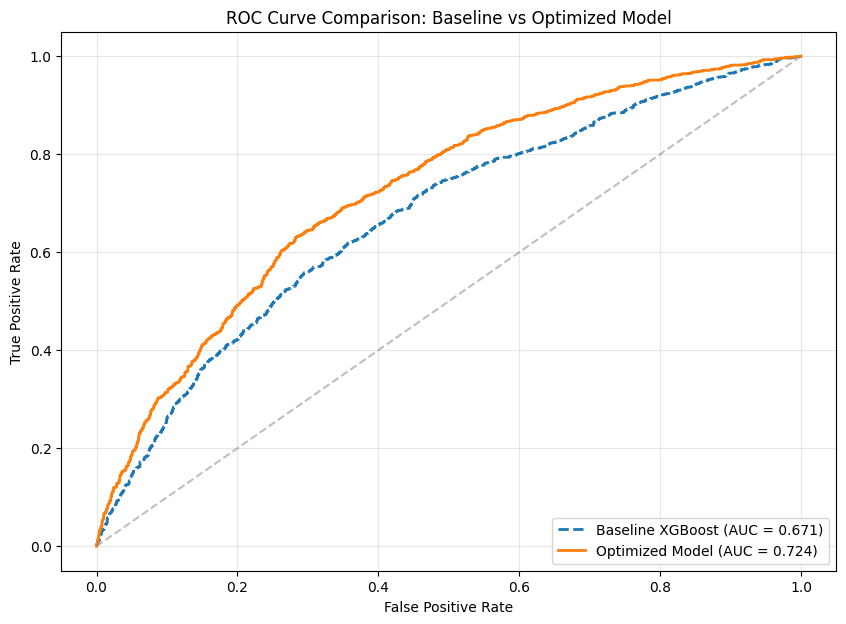

In [19]:
fpr_best, tpr_best, _ = roc_curve(y, y_pred_proba_best)
roc_auc_best = auc(fpr_best, tpr_best)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, lw=2, label=f'Baseline XGBoost (AUC = {roc_auc:.3f})', linestyle='--')
plt.plot(fpr_best, tpr_best, lw=2, label=f'Optimized Model (AUC = {roc_auc_best:.3f})')
plt.plot([0, 1], [0, 1], '--', color='grey', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Baseline vs Optimized Model')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

In [24]:
cv_scores = cross_val_score(best_pipeline, X, y, cv=cv)
print(f"Cross-validation ROC AUC scores: {cv_scores}")
print(f"Mean ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

C:\Users\Concordance\PycharmProjects\QRT-Challenge-2025\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning:

Features [ 12  13  22  37 120 128 131 151 152 155 165 166 168 175 180 181 194 202
 205 206 207 209 216 218 221 224] are constant.

C:\Users\Concordance\PycharmProjects\QRT-Challenge-2025\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning:

invalid value encountered in divide

C:\Users\Concordance\PycharmProjects\QRT-Challenge-2025\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning:

Features [ 12  13  16  22  37 123 125 129 151 152 155 165 166 168 175 180 181 194
 202 205 206 207 209 216 218 221 224] are constant.

C:\Users\Concordance\PycharmProjects\QRT-Challenge-2025\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning:

invalid value encountered in divide

C:\Users\Concordance\PycharmProjects\QRT-Challenge-202

Cross-validation ROC AUC scores: [0.68346457 0.66929134 0.66929134 0.67192429 0.65141956]
Mean ROC AUC: 0.6691 (+/- 0.0205)


In [21]:
best_pipeline.fit(X, y)
feature_selector = best_pipeline.named_steps['feature_selection']
selected_features_mask = feature_selector.get_support()
selected_features = X.columns[selected_features_mask].tolist()

print(f"\nSelected {len(selected_features)} features:")
print(selected_features)

C:\Users\Concordance\PycharmProjects\QRT-Challenge-2025\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:110: UserWarning:

Features [ 12  13  22  37 151 152 155 165 166 168 175 180 181 194 202 205 206 207
 209 216 218 221 224] are constant.

C:\Users\Concordance\PycharmProjects\QRT-Challenge-2025\.venv\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning:

invalid value encountered in divide




Selected 246 features:
['BM_BLAST', 'WBC', 'ANC', 'MONOCYTES', 'HB', 'PLT', 'is_abnormal', 'is_normal', 'total_chromosomes', 'monosomy_7', 'monosomy_5', 'del_20q', 't_15_17', 't_3_3', 'del_3_q26', 't_3_9', 'trisomy_8', 'complex_karyotype', 'eln_risk_ordinal', 'number_of_clones', 'numerical_anomalies_count', 'num_involved_chromosomes', 'chr_3_involved', 'chr_5_involved', 'chr_7_involved', 'chr_8_involved', 'chr_9_involved', 'chr_11_involved', 'chr_15_involved', 'chr_16_involved', 'chr_17_involved', 'chr_20_involved', 'chr_21_involved', 'chr_22_involved', 'complexity_score', 'tfidf_0', 'tfidf_1', 'tfidf_2', 'tfidf_3', 'tfidf_4', 'tfidf_5', 'tfidf_6', 'tfidf_7', 'tfidf_8', 'tfidf_9', 'tfidf_10', 'tfidf_11', 'tfidf_12', 'tfidf_13', 'tfidf_14', 'tfidf_15', 'tfidf_16', 'tfidf_17', 'tfidf_18', 'tfidf_19', 'tfidf_20', 'tfidf_21', 'tfidf_22', 'tfidf_23', 'tfidf_24', 'tfidf_25', 'tfidf_26', 'tfidf_27', 'tfidf_28', 'tfidf_29', 'tfidf_30', 'tfidf_31', 'tfidf_32', 'tfidf_33', 'tfidf_34', 'tfidf_35

In [22]:
if hasattr(best_pipeline.named_steps['classifier'], 'feature_importances_'):
    importances = best_pipeline.named_steps['classifier'].feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': selected_features,
        'importance': importances
    }).sort_values('importance', ascending=False)

    fig = px.bar(feature_importance_df.head(20), x='importance', y='feature',
                 orientation='h', title='Top 20 Feature Importances (Optimized Model)')
    fig.show()
